In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo'dan "-" öncesindeki dört rakamı çıkarıyoruz
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)

# mccinfo değeri bulunamayan satırları siliyoruz
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlarda formatlama işlemleri
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunlar için one-hot encoding
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

print("Ön işleme tamamlandı.")

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15
Ön işleme tamamlandı.


In [9]:

target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]


In [10]:
X

,mccinfo,Şehir,İlçe,basarili_satis_adet,basarili_satis_ciro,basarili_iade_adet,basarili_iade_ciro,Müşteri Skoru,bıst100_Kapanış,bıst100_Açılış,...,Euro_Açılış,Euro_Yüksek,Euro_Düşük,USD_Kapanış,USD_Açılış,USD_Yüksek,USD_Düşük,Yıl,Ay,Gün
0,105,60,248,247520,1.045249e+08,994,560218.63,58.62,1.492,1.484,...,8.8803,8.8847,8.6334,7.1883,7.3151,7.3177,7.1557,2021,2,1
1,101,60,46,10683,2.685102e+06,10,5521.15,64.08,1.408,1.405,...,9.5982,9.7193,9.5847,8.0567,8.0205,8.1204,8.0082,2021,4,16
2,55,60,247,289,3.024150e+04,67,3385.00,61.36,1.375,1.393,...,9.7186,9.7850,9.6501,8.1421,8.1655,8.2371,8.1015,2021,4,12
3,75,60,104,3,1.867700e+04,0,0.00,51.42,1.392,1.381,...,10.0075,10.0388,9.8691,8.1977,8.2827,8.3113,8.1688,2021,4,27
4,139,60,234,856,6.864042e+06,5,9880.55,44.88,1.392,1.381,...,10.0075,10.0388,9.8691,8.1977,8.2827,8.3113,8.1688,2021,4,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,37,60,146,6,1.164500e+04,0,0.00,56.40,10.872,10.715,...,35.1156,35.2801,34.9866,32.5130,32.5514,32.6390,32.4105,2024,7,4
1703,65,60,146,146,1.790288e+05,5,3357.76,68.90,10.872,10.715,...,35.1156,35.2801,34.9866,32.5130,32.5514,32.6390,32.4105,2024,7,4
1704,59,60,146,10,1.169149e+04,0,0.00,55.28,10.872,10.715,...,35.1156,35.2801,34.9866,32.5130,32.5514,32.6390,32.4105,2024,7,4
1705,115,60,146,1,3.000000e+02,0,0.00,63.60,11.139,11.194,...,36.1836,36.2896,35.9647,33.0488,33.0807,33.1745,32.9744,2024,7,18


In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression


# f_regression ile en iyi 10 özelliği seçiyoruz
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Seçilen Özellikler:", selected_features.tolist())

# XGBoost regressor'ı varsayılan parametrelerle başlatıyoruz.
model = XGBRegressor(random_state=42)

y_pred = cross_val_predict(model, X_selected, y, cv=10)

# Değerlendirme metriklerini hesaplıyoruz.
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

Seçilen Özellikler: ['İlçe', 'basarili_satis_adet', 'basarili_satis_ciro', 'basarili_iade_adet', 'basarili_iade_ciro', 'Müşteri Skoru', 'USD_Açılış', 'USD_Düşük', 'Ay', 'Gün']


MAE: 0.3102
MAPE: 0.0763
R2: 0.6580


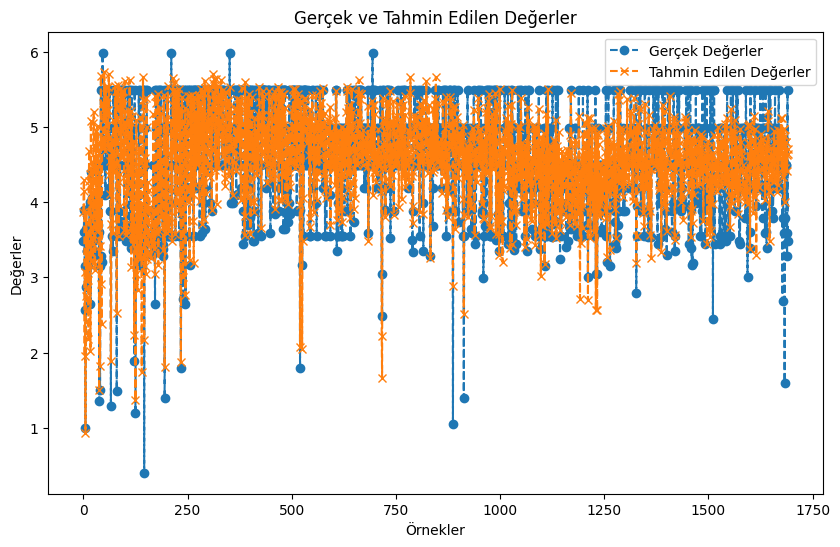

In [12]:
# -------------------- Grafik -------------------- #
plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label="Gerçek Değerler", marker="o", linestyle="--")
plt.plot(range(len(y_pred)), y_pred, label="Tahmin Edilen Değerler", marker="x", linestyle="--")
plt.xlabel("Örnekler")
plt.ylabel("Değerler")
plt.title("Gerçek ve Tahmin Edilen Değerler")
plt.legend()
plt.show()
